## ACS Income Data Distributions

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

## 4.1 Non-private data processing

In [2]:
# Read in sample directly
adult_data = pd.read_csv('acs_income_data_sample.csv', index_col=False)

In [3]:
def process_adult_new(df):

    # Remove fnlwgt and native_country column 
    df = df.drop(["native_country", "Unnamed: 0"], axis=1)
    
    # Remove missing values
    df = df[~df.eq("?").any(1)]
    
    # Normalize the numerical features
    #numerical_features = ["age", "hours_week"]
    #scaler = MinMaxScaler()
    #df[numerical_features] = scaler.fit_transform(df[numerical_features])
    
    # Encode the categorical features
    categorical_features = ["race", "occupation", "marital", "education", "workclass", "relationship"]
    df['race'] = pd.factorize(df['race'])[0]
    df['occupation'] = pd.factorize(df['occupation'])[0]
    df['marital'] = pd.factorize(df['marital'])[0]
    df['education'] = pd.factorize(df['education'])[0]
    df['workclass'] = pd.factorize(df['workclass'])[0]
    df['relationship'] = pd.factorize(df['relationship'])[0]

    # Keep separate variabels with labels of outcome + protected classes for downstream plots, tables, etc
    df["gender_labs"] = df["sex"]
    
    # Map binary features to 0/1
    df["sex"] = df["sex"].map({"Female":0, "Male":1})
    df["label"] = df["label"].map({"<=50K":0, ">50K":1})

    df["over_under_50k"] = df["label"]

    return df

In [4]:
# Get the processed replacement adult data
processed_adult = process_adult_new(adult_data)
processed_adult

,label,race,sex,hours_week,occupation,marital,education,workclass,age,relationship,gender_labs,over_under_50k
0,1,0,0,40.0,0,0,0,0,41.0,0,Female,1
1,0,0,0,25.0,1,0,1,0,19.0,1,Female,0
2,0,0,0,20.0,2,0,0,0,41.0,2,Female,0
3,0,0,0,25.0,3,1,1,0,56.0,0,Female,0
4,0,1,1,40.0,4,2,1,0,25.0,1,Male,0
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,1,0,1,40.0,19,1,5,0,64.0,4,Male,1
29996,1,0,0,40.0,17,0,0,0,37.0,0,Female,1
29997,1,0,0,30.0,7,0,5,2,62.0,2,Female,1
29998,0,0,1,40.0,17,2,4,4,27.0,11,Male,0


In [5]:
# Split processed data into train and test
non_priv_data = processed_adult.drop(["gender_labs", "over_under_50k"], axis=1)
non_priv_train, non_priv_test = train_test_split(non_priv_data, test_size=0.2, random_state=0)
non_priv_train = non_priv_train.reset_index(drop=True)
non_priv_train

,label,race,sex,hours_week,occupation,marital,education,workclass,age,relationship
0,1,0,1,50.0,7,1,2,0,47.0,4
1,1,0,1,48.0,12,0,6,0,50.0,0
2,1,0,0,40.0,7,0,5,3,67.0,2
3,0,0,0,40.0,20,0,8,0,54.0,0
4,1,0,1,45.0,11,2,6,7,57.0,0
...,...,...,...,...,...,...,...,...,...,...
23995,0,0,1,40.0,20,0,1,0,32.0,0
23996,0,1,0,40.0,11,2,0,3,30.0,0
23997,1,0,1,50.0,11,0,0,0,50.0,0
23998,0,0,0,45.0,2,2,0,0,34.0,1


In [6]:
def get_classification_summary(train_df, test_df, classifier="forest", evaluate="test", feature_importance=False):
    
    # Train the classification model
    X_train, y_train = train_df.drop("label", axis=1), train_df["label"]
    X_test, y_test = test_df.drop("label", axis=1), test_df["label"]
    if classifier == "logistic":
        m = LogisticRegression(max_iter=1000, C=1., penalty="l2")
        m.fit(X_train, y_train)
    elif classifier == "forest":
        m = RandomForestClassifier(random_state=0)
        m.fit(X_train, y_train)
    else:
        raise Exception(f"Classifier {classifier} not recognized.")
        
    # Get features importances
    if feature_importance:
        features = train_df.columns
        if classifier == "logistic":
            importances = np.abs(m.coef_)[0]
        elif classifier == "forest":
            importances = m.feature_importances_
        sorted_coef_idx = np.argsort(importances)[::-1]
        sorted_coef = importances[sorted_coef_idx]
        sorted_features = features[sorted_coef_idx]
        print("FEATURE IMPORTANCE:\n")
        for feature, coef in zip(sorted_features, sorted_coef):
            print(f"Feature: {feature}, Impor: {coef}")
            
    # Predict on the train and test data
    y_train_pred = m.predict(X_train)
    y_test_pred = m.predict(X_test)
    
    # Get the all classification metrics
    if evaluate == "test":
        df = X_test.copy()
        df["y"] = y_test
        df["y_pred"] = y_test_pred
    else:
        df = X_train.copy()
        df["y"] = y_train
        df["y_pred"] = y_train_pred
    TP_f = len(df[(df["sex"]==0) & (df["y"]==1) & (df["y_pred"]==1)])
    TP_m = len(df[(df["sex"]==1) & (df["y"]==1) & (df["y_pred"]==1)])
    FP_f = len(df[(df["sex"]==0) & (df["y"]==0) & (df["y_pred"]==1)])
    FP_m = len(df[(df["sex"]==1) & (df["y"]==0) & (df["y_pred"]==1)])
    TN_f = len(df[(df["sex"]==0) & (df["y"]==0) & (df["y_pred"]==0)])
    TN_m = len(df[(df["sex"]==1) & (df["y"]==0) & (df["y_pred"]==0)])
    FN_f = len(df[(df["sex"]==0) & (df["y"]==1) & (df["y_pred"]==0)])
    FN_m = len(df[(df["sex"]==1) & (df["y"]==1) & (df["y_pred"]==0)])
    TPR_f = TP_f / (TP_f + FN_f)
    TPR_m = TP_m / (TP_m + FN_m)
    FPR_f = FP_f / (FP_f + TN_f)
    FPR_m = FP_m / (FP_m + TN_m)
    TPR_diff = TPR_m - TPR_f
    FPR_diff = FPR_m - FPR_f
    ACC_f = (TP_f + TN_f) / sum([TP_f, FP_f, TN_f, FN_f])
    ACC_m = (TP_m + TN_m) / sum([TP_m, FP_m, TN_m, FN_m])
    F1_score = (TP_f+TP_m) / (TP_f+TP_m + 0.5*(FP_f+FP_m + FN_f+FN_m))
    
    # Print out results
    print(f"\nCLASSIFICATION RESULTS ({classifier}, eval on test data)\n")
    print("True positive rates:")
    print(f"Female: {TPR_f:.4f}, Male: {TPR_m:.4f}\n")
    print("False positive rates:")
    print(f"Female: {FPR_f:.4f}, Male: {FPR_m:.4f}\n")
    print("Equalized odds distances:")
    print(f"y=1: {TPR_diff:.4f}, y=0: {FPR_diff:.4f}\n")
    print("Classification accuracies:")
    print(f"Female: {ACC_f:.4f}, Male: {ACC_m:.4f}\n")
    print(f"F1-score: {F1_score:.4f}\n")
    
    return y_train_pred, y_test_pred

In [30]:
df = adult_data
race = pd.factorize(df['race'])[1]
occupation = pd.factorize(df['occupation'])[1]
marital = pd.factorize(df['marital'])[1]
education = pd.factorize(df['education'])[1]
workclass = pd.factorize(df['workclass'])[1]
relationship = pd.factorize(df['relationship'])[1]

sex = ["Female", "Male"]
label = ["<=50K", ">50K"]

In [33]:
def plot_distributions(df, title):
    continuous = ["age", "education_num", "hours_week"]
    categorical_labels = {"workclass": workclass, "education": education, 
                          "occupation": occupation, "relationship": relationship, 
                          "race": race, "sex": sex, "label": label, "marital": marital}
    fig, ax = plt.subplots(2, 5, figsize=(20,8))
    ax = ax.ravel()
    for i, col in enumerate(df.columns):
        if col in continuous:
            sns.histplot(data=df, x=col, hue="label", multiple="stack", ax=ax[i], discrete=True)
        else:
            labels = categorical_labels[col]
            g = sns.histplot(data=df, x=col, hue="label", multiple="stack", ax=ax[i], discrete=True)
            g.set_xticks(list(range(len(labels))))
            g.set_xticklabels(labels, rotation=45)
    fig.suptitle(title, size=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [8]:
data_dir = "acs_income/"

## 2. Non-private data distributions

In [14]:
non_priv_train.columns

Index(['label', 'race', 'sex', 'hours_week', 'occupation', 'marital',
       'education', 'workclass', 'age', 'relationship'],
      dtype='object')

<ipython-input-33-6749f83c37f3>:17: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])


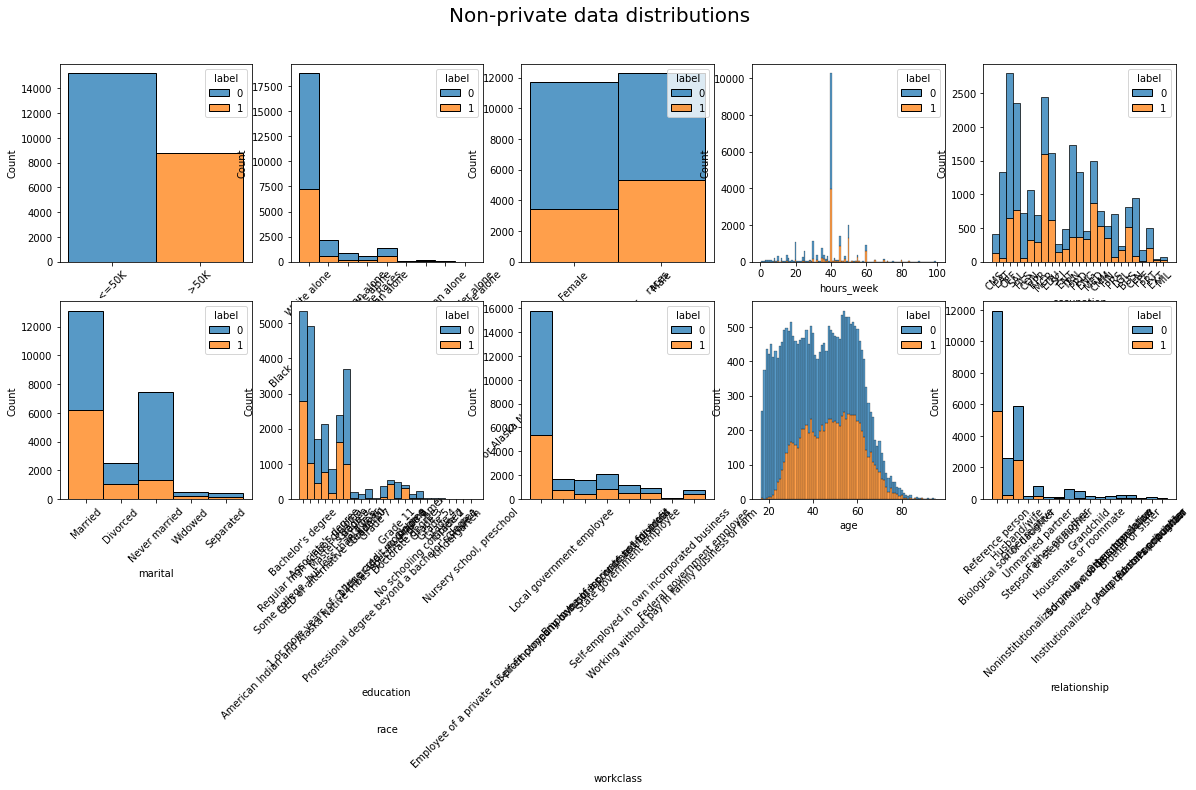

In [34]:
# Plot the non-private distributions
plot_distributions(non_priv_train, title="Non-private data distributions")

In [35]:
y_train_pred, y_test_pred = get_classification_summary(non_priv_train, non_priv_test, classifier="logistic", feature_importance=True)
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")

FEATURE IMPORTANCE:

Feature: race, Impor: 0.3831236107782068
Feature: occupation, Impor: 0.2896919150646911
Feature: age, Impor: 0.1349631699129419
Feature: education, Impor: 0.07141464587861876
Feature: sex, Impor: 0.06247548788563065
Feature: hours_week, Impor: 0.03928797588830903
Feature: workclass, Impor: 0.031421376627528905
Feature: marital, Impor: 0.015399798300298818
Feature: label, Impor: 0.004690615385396734

CLASSIFICATION RESULTS (logistic, eval on test data)

True positive rates:
Female: 0.2511, Male: 0.6701

False positive rates:
Female: 0.0807, Male: 0.2553

Equalized odds distances:
y=1: 0.4190, y=0: 0.1746

Classification accuracies:
Female: 0.7154, Male: 0.7127

F1-score: 0.5662

Avg train pred: 0.2913, Avg test pred: 0.2895


In [36]:
y_train_pred, y_test_pred = get_classification_summary(non_priv_train, non_priv_test, feature_importance=True)
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")

FEATURE IMPORTANCE:

Feature: workclass, Impor: 0.2686408877143223
Feature: sex, Impor: 0.17683947010061685
Feature: hours_week, Impor: 0.17487063647351236
Feature: marital, Impor: 0.12155553582242731
Feature: education, Impor: 0.06701617833149591
Feature: occupation, Impor: 0.06169143111310008
Feature: age, Impor: 0.05915771745119752
Feature: label, Impor: 0.040878748690242224
Feature: race, Impor: 0.029349394303085544

CLASSIFICATION RESULTS (forest, eval on test data)

True positive rates:
Female: 0.5890, Male: 0.7036

False positive rates:
Female: 0.1248, Male: 0.1976

Equalized odds distances:
y=1: 0.1146, y=0: 0.0728

Classification accuracies:
Female: 0.7879, Male: 0.7600

F1-score: 0.6824

Avg train pred: 0.3666, Avg test pred: 0.3438


## 3. MWEM data distributions

<ipython-input-33-6749f83c37f3>:17: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])


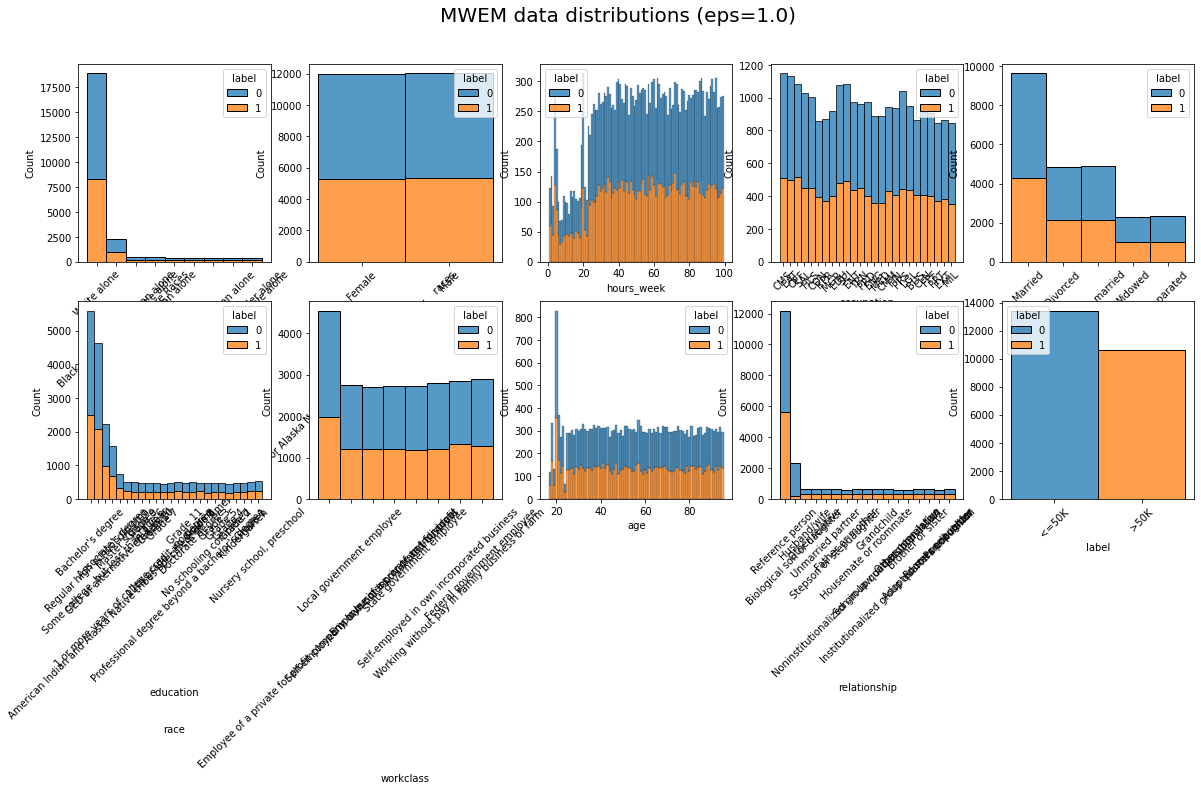

In [38]:
MWEM_eps1_rep1 = pd.read_csv(data_dir+"saved_synthetic_data_mwem_dpctgan/acs_income_MWEM_no_quail_eps=1.0_rep=1.csv", index_col=0)
plot_distributions(MWEM_eps1_rep1, title="MWEM data distributions (eps=1.0)")

In [39]:
y_train_pred, y_test_pred = get_classification_summary(MWEM_eps1_rep1, non_priv_test)
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (forest, eval on test data)

True positive rates:
Female: 0.3961, Male: 0.3343

False positive rates:
Female: 0.3729, Male: 0.3326

Equalized odds distances:
y=1: -0.0618, y=0: -0.0403

Classification accuracies:
Female: 0.5566, Male: 0.5244

F1-score: 0.3657

Avg train pred: 0.4409, Avg test pred: 0.3557


## 4. DP-CTGAN data distributions

<ipython-input-33-6749f83c37f3>:17: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])


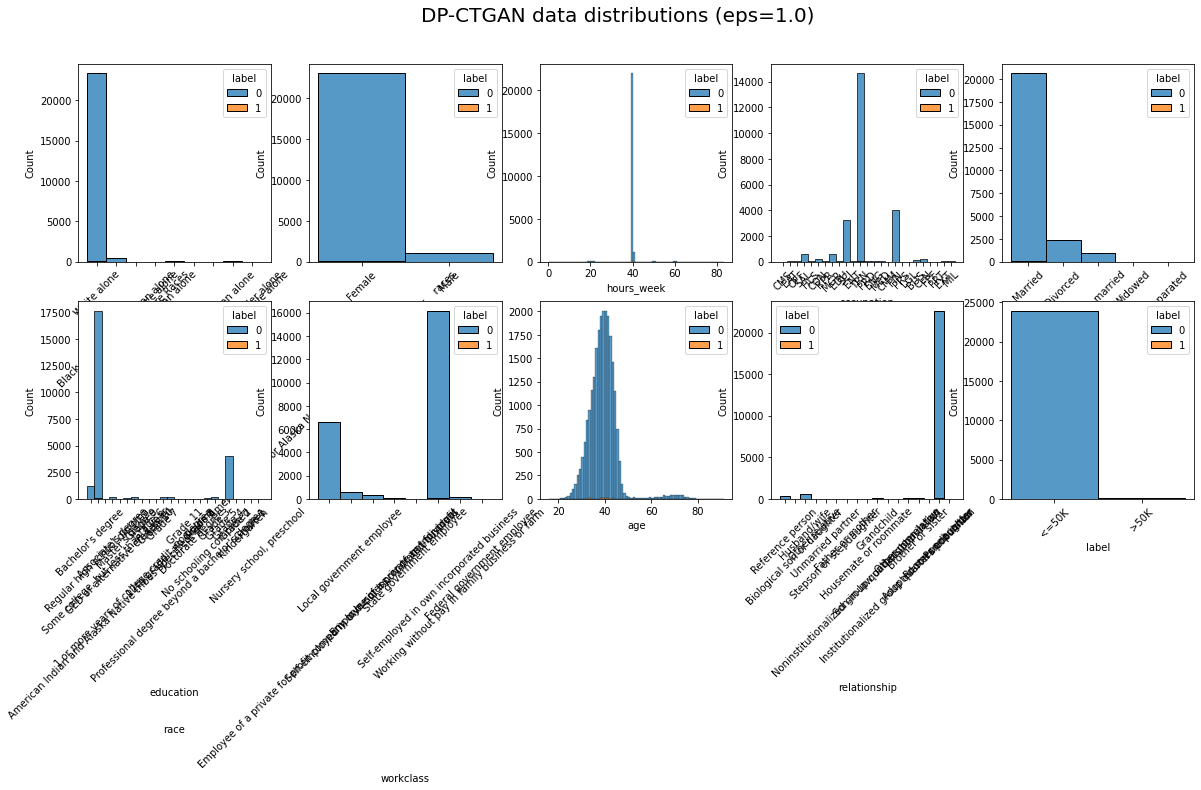

In [42]:
DPCTGAN_eps1_rep9 = pd.read_csv(data_dir+"saved_synthetic_data_mwem_dpctgan/acs_income_DPCTGAN_no_quail_eps=1.0_rep=9.csv", index_col=0)
plot_distributions(DPCTGAN_eps1_rep9, title="DP-CTGAN data distributions (eps=1.0)")

In [43]:
y_train_pred, y_test_pred = get_classification_summary(DPCTGAN_eps1_rep9, non_priv_test)
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (forest, eval on test data)

True positive rates:
Female: 0.0011, Male: 0.0000

False positive rates:
Female: 0.0010, Male: 0.0000

Equalized odds distances:
y=1: -0.0011, y=0: -0.0010

Classification accuracies:
Female: 0.6945, Male: 0.5708

F1-score: 0.0009

Avg train pred: 0.0027, Avg test pred: 0.0005


<ipython-input-33-6749f83c37f3>:17: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])


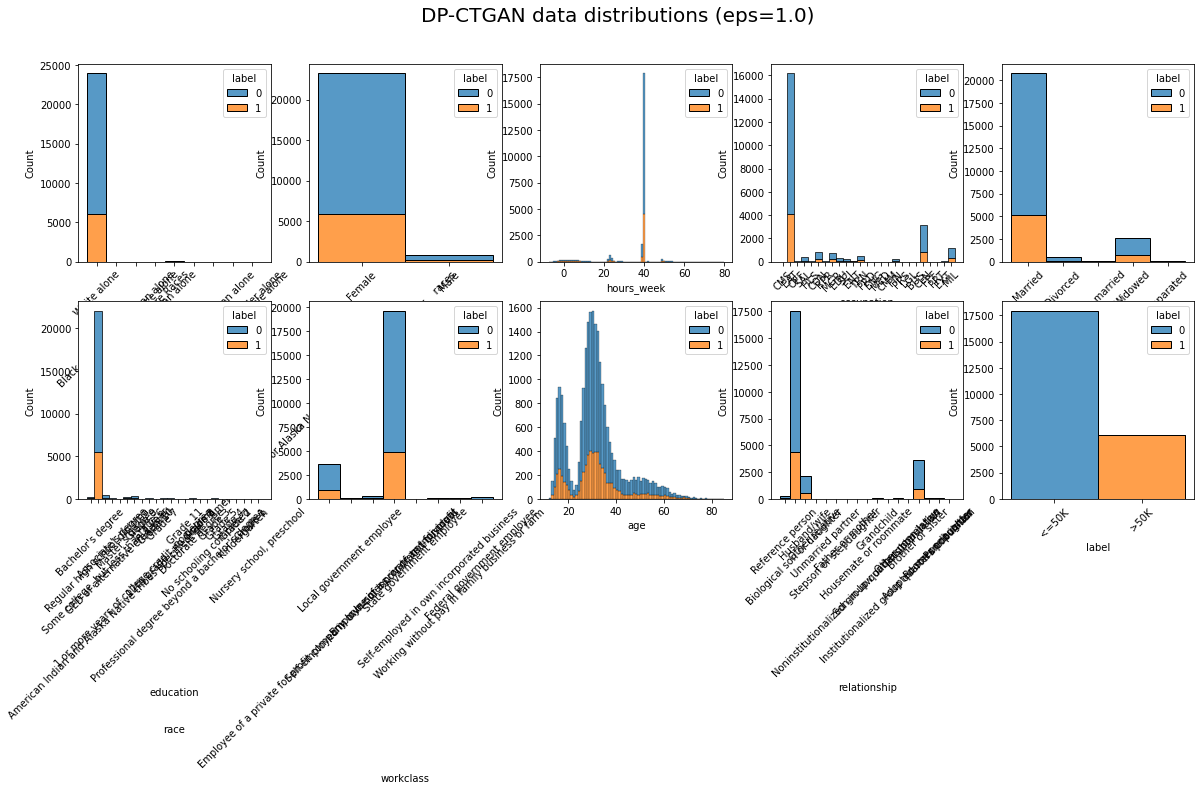

In [44]:
DPCTGAN_eps1_rep1 = pd.read_csv(data_dir+"saved_synthetic_data_mwem_dpctgan/acs_income_DPCTGAN_no_quail_eps=1.0_rep=1.csv", index_col=0)
plot_distributions(DPCTGAN_eps1_rep1, title="DP-CTGAN data distributions (eps=1.0)")

In [45]:
y_train_pred, y_test_pred = get_classification_summary(DPCTGAN_eps1_rep1, non_priv_test)
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (forest, eval on test data)

True positive rates:
Female: 0.0354, Male: 0.0171

False positive rates:
Female: 0.0251, Male: 0.0235

Equalized odds distances:
y=1: -0.0183, y=0: -0.0015

Classification accuracies:
Female: 0.6883, Male: 0.5647

F1-score: 0.0457

Avg train pred: 0.2523, Avg test pred: 0.0243


<ipython-input-33-6749f83c37f3>:17: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])


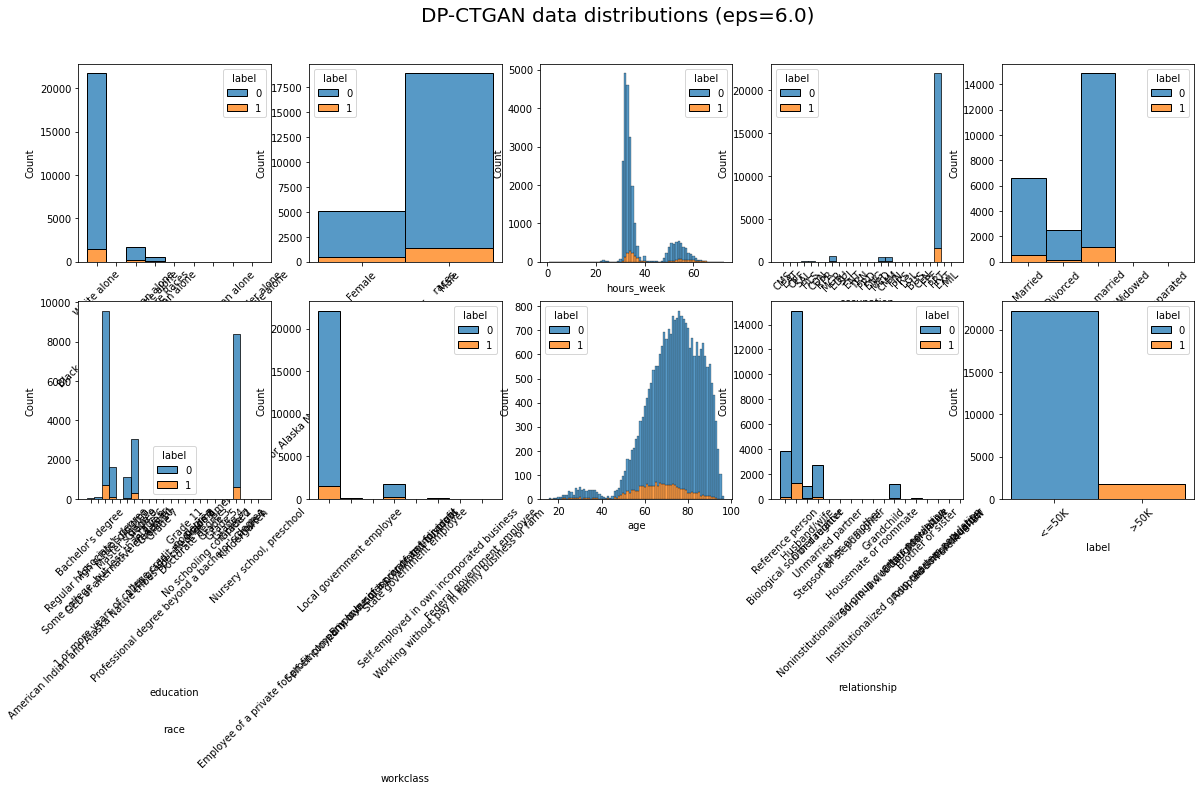

In [46]:
DPCTGAN_eps6_rep4 = pd.read_csv(data_dir+"saved_synthetic_data_mwem_dpctgan/acs_income_DPCTGAN_no_quail_eps=6.0_rep=4.csv", index_col=0)
plot_distributions(DPCTGAN_eps6_rep4, title="DP-CTGAN data distributions (eps=6.0)")

In [47]:
y_train_pred, y_test_pred = get_classification_summary(DPCTGAN_eps6_rep4, non_priv_test)
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (forest, eval on test data)

True positive rates:
Female: 0.0160, Male: 0.0335

False positive rates:
Female: 0.0135, Male: 0.0263

Equalized odds distances:
y=1: 0.0175, y=0: 0.0128

Classification accuracies:
Female: 0.6904, Male: 0.5702

F1-score: 0.0502

Avg train pred: 0.0739, Avg test pred: 0.0222


## 5. PATE-CTGAN data distributions

<ipython-input-33-6749f83c37f3>:17: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])


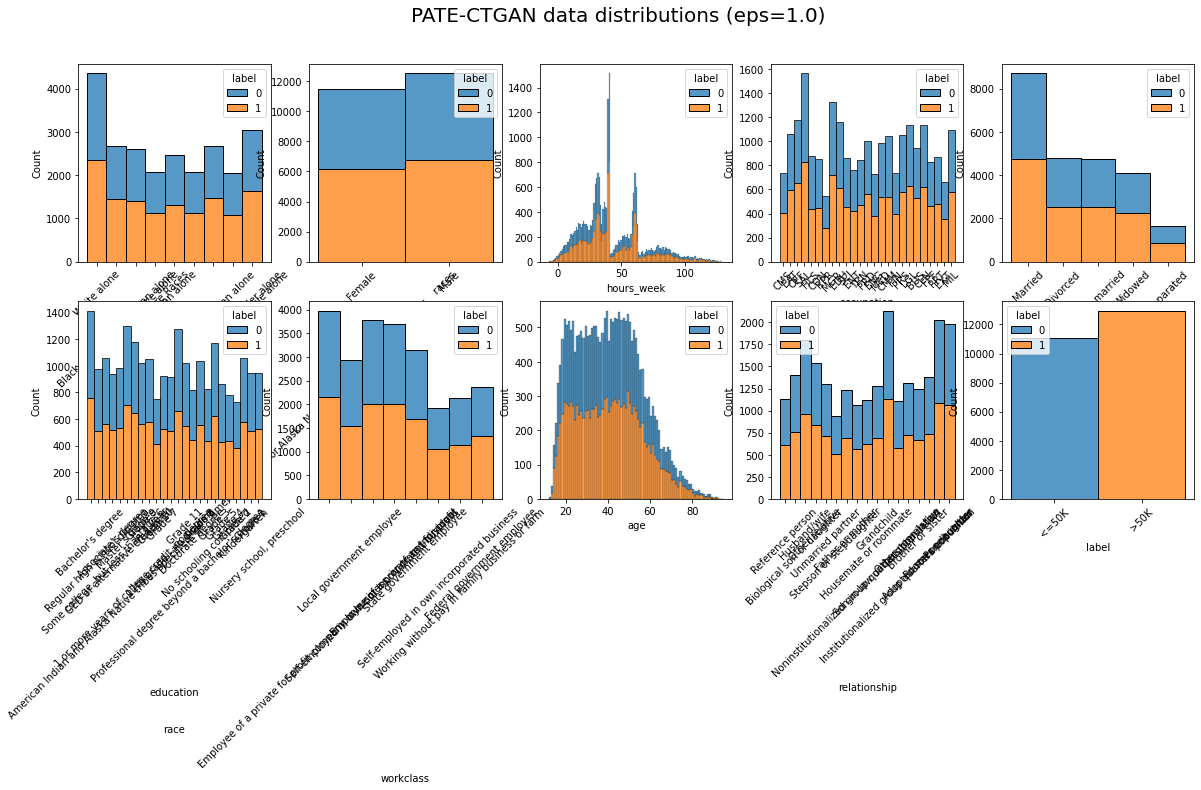

In [50]:
PATECTGAN_eps1_rep1 = pd.read_csv(data_dir+"PATECTGAN_eps=1.0_rep=1.csv", index_col=0)
plot_distributions(PATECTGAN_eps1_rep1, title="PATE-CTGAN data distributions (eps=1.0)")

In [51]:
y_train_pred, y_test_pred = get_classification_summary(PATECTGAN_eps1_rep1, non_priv_test, classifier="logistic", evaluate="test", feature_importance=False)
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (logistic, eval on test data)

True positive rates:
Female: 1.0000, Male: 1.0000

False positive rates:
Female: 1.0000, Male: 1.0000

Equalized odds distances:
y=1: 0.0000, y=0: 0.0000

Classification accuracies:
Female: 0.3051, Male: 0.4292

F1-score: 0.5400

Avg train pred: 1.0000, Avg test pred: 1.0000


In [52]:
y_train_pred, y_test_pred = get_classification_summary(PATECTGAN_eps1_rep1, non_priv_test, classifier="forest", evaluate="test", feature_importance=False)
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (forest, eval on test data)

True positive rates:
Female: 0.6838, Male: 0.6515

False positive rates:
Female: 0.6496, Male: 0.6848

Equalized odds distances:
y=1: -0.0323, y=0: 0.0351

Classification accuracies:
Female: 0.4521, Male: 0.4596

F1-score: 0.4746

Avg train pred: 0.5395, Avg test pred: 0.6655


In [62]:
def adult_classification_helper(synthesizer, quail, eps, rep, classifier, test_df, non_priv_results=False):
    """ helper function to calculate TPR_diff, FPR_diff, and F1_score for a single synthesizer, eps, rep, and classifier """
    
    # Read in the synthetic training data or use non-private data
    if non_priv_results:
        train_df = non_priv_train
        
    elif synthesizer == "PATECTGAN":
        fname = f"acs_income/{synthesizer}_eps={eps}_rep={rep}.csv"
        train_df = pd.read_csv(fname, index_col=0)
    
    elif quail == False:
        #data_dir+"saved_synthetic_data_mwem_dpctgan/acs_income_DPCTGAN_no_quail_eps=1.0_rep=1.csv", index_col=0)
        fname = f"acs_income/saved_synthetic_data_mwem_dpctgan/acs_income_{synthesizer}_no_quail_eps={eps}_rep={rep+1}.csv"
        train_df = pd.read_csv(fname, index_col=0)
    else:
        #data_dir+"saved_synthetic_data_mwem_dpctgan/acs_income_DPCTGAN_no_quail_eps=1.0_rep=1.csv", index_col=0)
        fname = f"acs_income/saved_synthetic_data_mwem_dpctgan/acs_income_{synthesizer}_quail_eps={eps}_rep={rep+1}.csv"
        train_df = pd.read_csv(fname, index_col=0)

    # Train the classification model
    X_train, y_train = train_df.drop("label", axis=1), train_df["label"]
    X_test, y_test = test_df.drop("label", axis=1), test_df["label"]
    if classifier == "logistic":
        m = LogisticRegression(max_iter=1000, C=1., penalty="l2")
        m.fit(X_train, y_train)
    elif classifier == "forest":
        m = RandomForestClassifier(random_state=0)
        m.fit(X_train, y_train)
    else:
        raise Exception(f"Classifier {classifier} not recognized.")

    # Predict on the test set
    y_test_pred = m.predict(X_test)

    # Get the all classification metrics on the test set
    df = X_test.copy()
    df["y"] = y_test
    df["y_pred"] = y_test_pred
    TP_f = len(df[(df["sex"]==0) & (df["y"]==1) & (df["y_pred"]==1)])
    TP_m = len(df[(df["sex"]==1) & (df["y"]==1) & (df["y_pred"]==1)])
    FP_f = len(df[(df["sex"]==0) & (df["y"]==0) & (df["y_pred"]==1)])
    FP_m = len(df[(df["sex"]==1) & (df["y"]==0) & (df["y_pred"]==1)])
    TN_f = len(df[(df["sex"]==0) & (df["y"]==0) & (df["y_pred"]==0)])
    TN_m = len(df[(df["sex"]==1) & (df["y"]==0) & (df["y_pred"]==0)])
    FN_f = len(df[(df["sex"]==0) & (df["y"]==1) & (df["y_pred"]==0)])
    FN_m = len(df[(df["sex"]==1) & (df["y"]==1) & (df["y_pred"]==0)])
    TPR_f = TP_f / (TP_f + FN_f)
    TPR_m = TP_m / (TP_m + FN_m)
    FPR_f = FP_f / (FP_f + TN_f)
    FPR_m = FP_m / (FP_m + TN_m)
    TPR_diff = TPR_m - TPR_f
    FPR_diff = FPR_m - FPR_f
    f1_score = (TP_f+TP_m) / (TP_f+TP_m + 0.5*(FP_f+FP_m + FN_f+FN_m))
    
    return TPR_diff, FPR_diff, f1_score

In [73]:
def get_adult_table_metrics(synthesizer, quail, epsilon_list, nreps, classifier, test_df):
    """ return median TPR_diff, FPR_diff, F1_score across all epsilons and repetitions """
    
    # Initialize lists
    tpr_diff_list = []
    fpr_diff_list = []
    f1_scores = []
    
    # Loop through the epsilon values and repetitions
    for eps in epsilon_list:
        for rep in range(nreps):

            # Get the classification metrics
            TPR_diff, FPR_diff, f1_score = adult_classification_helper(synthesizer, quail, eps, rep, classifier, test_df)
            
            # Append metrics to lists
            tpr_diff_list.append(TPR_diff)
            fpr_diff_list.append(FPR_diff)
            f1_scores.append(f1_score)
            
    # Get medians
    tpr_diff_median = np.median(tpr_diff_list)
    fpr_diff_median = np.median(fpr_diff_list)
    f1_score_median = np.median(f1_scores)
    
    return tpr_diff_median, fpr_diff_median, f1_score_median

def get_adult_plot_metrics(synthesizer, quail, epsilon_list, nreps, classifier, test_df):
    """ return median and std of TPR_diff, FPR_diff, F1_score for *each* epsilon value (arrays of values) """
    
    # Initialize lists
    tpr_diff_median_list = []
    fpr_diff_median_list = []
    f1_score_medians = []
    tpr_diff_std_list = []
    fpr_diff_std_list = []
    f1_score_std_list = []
    
    # Loop through the epsilon values and repetitions
    for eps in epsilon_list:
        
        # Initialize list to hold values for each epsilon value
        tpr_diff_list = []
        fpr_diff_list = []
        f1_scores = []
        
        # Loop through the range of repetitions
        for rep in range(nreps):

            # Get the classification metrics
            TPR_diff, FPR_diff, f1_score = adult_classification_helper(synthesizer, quail, eps, rep, classifier, test_df)   
            
            # Append metrics to lists
            tpr_diff_list.append(TPR_diff)
            fpr_diff_list.append(FPR_diff)
            f1_scores.append(f1_score)
            
        # Append medians to lists
        tpr_diff_median_list.append(np.median(tpr_diff_list))
        fpr_diff_median_list.append(np.median(fpr_diff_list))
        f1_score_medians.append(np.median(f1_scores))
        tpr_diff_std_list.append(np.std(tpr_diff_list))
        fpr_diff_std_list.append(np.std(fpr_diff_list))
        f1_score_std_list.append(np.std(f1_scores))
        
    return tpr_diff_median_list, fpr_diff_median_list, f1_score_medians, tpr_diff_std_list, fpr_diff_std_list, f1_score_std_list
        
def get_adult_epsilon_plots(synthesizer_list, quail, epsilon_list, nreps, classifier, test_df, non_priv_results=True):
    """ return subplot with three plots showing graphs of TPR_diff, FPR_diff, F1_score acros epsilons for each synthesizer """
    
    # Initialize subplots
    fig, ax = plt.subplots(1, 3, figsize=(16,5))
    
    # Loop through the synthesizers
    for synth in synthesizer_list:
        
        # Get all classification metrics
        tpr_diff_median_list, fpr_diff_median_list, f1_score_medians, tpr_diff_std_list, fpr_diff_std_list, f1_score_std_list \
        =  get_adult_plot_metrics(synth, quail, epsilon_list, nreps, classifier, test_df)
        
        # Plot the metrics with error bars
        ax[0].errorbar(epsilon_list, tpr_diff_median_list, tpr_diff_std_list, label=synth)
        ax[1].errorbar(epsilon_list, fpr_diff_median_list, fpr_diff_std_list, label=synth)
        ax[2].errorbar(epsilon_list, f1_score_medians, f1_score_std_list, label=synth)
        
    # Add the non-private results to the plots
    non_priv_tpr_diff, non_priv_fpr_diff, non_priv_f1_score = adult_classification_helper(None, None, None, None, classifier, test_df, non_priv_results=True)
    ax[0].hlines(non_priv_tpr_diff, xmin=epsilon_list[0], xmax=epsilon_list[-1], linestyles="--", label="Non-private data")
    ax[1].hlines(non_priv_fpr_diff, xmin=epsilon_list[0], xmax=epsilon_list[-1], linestyles="--", label="Non-private data")
    ax[2].hlines(non_priv_f1_score, xmin=epsilon_list[0], xmax=epsilon_list[-1], linestyles="--", label="Non-private data")
        
    # Plotting details
    for i in range(3):
        ax[i].set_xlabel("Privacy budget")
        ax[i].legend()
    ax[0].set_ylabel("Equalized odds distance ($y=1$)")
    ax[1].set_ylabel("Equalized odds distance ($y=0$)")
    ax[2].set_ylabel("F1-score")
    if classifier == "logistic":
        title = f"ACS Income classification summary (logistic regression)"
    elif classifier == "forest":
        title = f"ACS Income classification summary (random forest)"
    fig.suptitle(title, size=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [68]:
# Specify list of epsilons
epsilon_list=[1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0]

### MWEM (no quail)

In [81]:
# Plot the table metrics for MWEM (no quail) with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_adult_table_metrics("MWEM", quail = False, epsilon_list=epsilon_list, nreps=10, classifier="logistic", test_df=non_priv_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

# Plot the table metrics for MWEM (no quail) with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_adult_table_metrics("MWEM", quail = False, epsilon_list=epsilon_list, nreps=10, classifier="forest", test_df=non_priv_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: -0.001
FPR difference median: 0.019
F1-score median: 0.011
TPR difference median: 0.005
FPR difference median: -0.012
F1-score median: 0.390


### MWEM (quail)

In [82]:
# Plot the table metrics for MWEM (quail) with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_adult_table_metrics("MWEM", quail = True, epsilon_list=epsilon_list, nreps=10, classifier="logistic", test_df=non_priv_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

# Plot the table metrics for MWEM (quail) with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_adult_table_metrics("MWEM", quail = True, epsilon_list=epsilon_list, nreps=10, classifier="forest", test_df=non_priv_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.306
FPR difference median: 0.182
F1-score median: 0.529
TPR difference median: 0.269
FPR difference median: 0.166
F1-score median: 0.526


### DPCTGAN (no quail)

In [78]:
# Plot the table metrics for DPCTGAN (no quail) with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_adult_table_metrics("DPCTGAN", quail = False, epsilon_list=epsilon_list, nreps=10, classifier="logistic", test_df=non_priv_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

# Plot the table metrics for DPCTGAN (no quail) with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_adult_table_metrics("DPCTGAN", quail = False, epsilon_list=epsilon_list, nreps=10, classifier="forest", test_df=non_priv_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.000
FPR difference median: 0.000
F1-score median: 0.029
TPR difference median: 0.000
FPR difference median: 0.000
F1-score median: 0.217


### DPCTGAN (quail)

In [79]:
# Plot the table metrics for DPCTGAN (quail) with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_adult_table_metrics("DPCTGAN", quail = True, epsilon_list=epsilon_list, nreps=10, classifier="logistic", test_df=non_priv_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

# Plot the table metrics for DPCTGAN (quail) with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_adult_table_metrics("DPCTGAN", quail = True, epsilon_list=epsilon_list, nreps=10, classifier="forest", test_df=non_priv_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.114
FPR difference median: 0.036
F1-score median: 0.482
TPR difference median: 0.094
FPR difference median: 0.031
F1-score median: 0.463


### PATECTGAN (no quail)

In [83]:
# Plot the table metrics for PATECTGAN (no quail) with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_adult_table_metrics("PATECTGAN", quail = False, epsilon_list=epsilon_list, nreps=10, classifier="logistic", test_df=non_priv_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

# Plot the table metrics for PATECTGAN (no quail) with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_adult_table_metrics("PATECTGAN", quail = False, epsilon_list=epsilon_list, nreps=10, classifier="forest", test_df=non_priv_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.000
FPR difference median: 0.000
F1-score median: 0.000
TPR difference median: 0.007
FPR difference median: 0.003
F1-score median: 0.207


### PATECTGAN (quail)

In [ ]:
# TODO

### NonPrivate Data

In [ ]:
# Above

## Plots

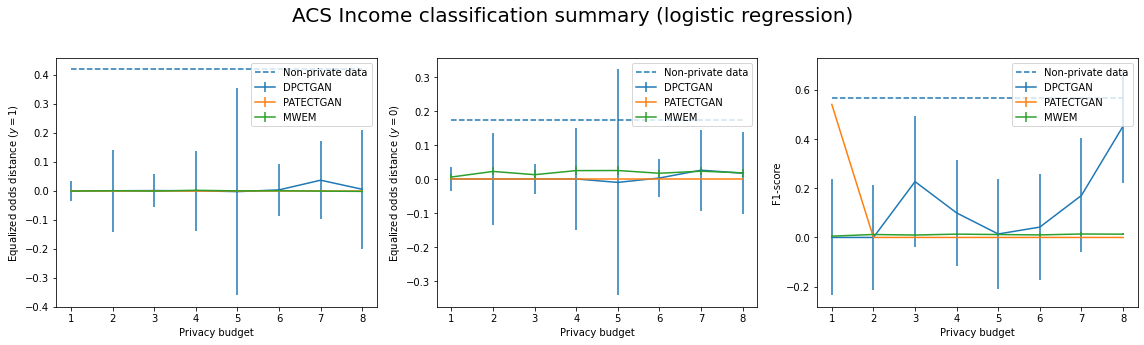

In [84]:
# Plot classification summary for logistic regression
get_adult_epsilon_plots(["DPCTGAN", "PATECTGAN", "MWEM"], quail = False, epsilon_list=epsilon_list, nreps=10, classifier="logistic", test_df=non_priv_test, non_priv_results=True)

In [ ]:
# Plot classification summary for random forest
get_adult_epsilon_plots(["DPCTGAN", "PATECTGAN", "MWEM"], quail = False, epsilon_list=epsilon_list, nreps=10, classifier="forest", test_df=non_priv_test, non_priv_results=True)

In [ ]:
# Plot classification summary for logistic regression with quail
get_adult_epsilon_plots(["DPCTGAN", "MWEM"], quail = True, epsilon_list=epsilon_list, nreps=10, classifier="logistic", test_df=non_priv_test, non_priv_results=True)

In [ ]:
# Plot classification summary for random forest with quail
get_adult_epsilon_plots(["DPCTGAN", "MWEM"], quail = True, epsilon_list=epsilon_list, nreps=10, classifier="forest", test_df=non_priv_test, non_priv_results=True)